# House Prices - Artificial Neural Network - Numericals

In [1]:
!pip install keras
!pip install tensorflow

Import Modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid', context='notebook', palette='deep')

import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

%config InlineBackend.figure_format = 'retina'

Import Datasets

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

Check Datasets size

In [4]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore Data

In [6]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can see that the mean value is around 180 000 USD and we can say with standard deviation : 100 000 USD < 68% of the data < 260 000 USD

Visualization

Skew is: 1.8828757597682129
Kurt is: 6.536281860064529


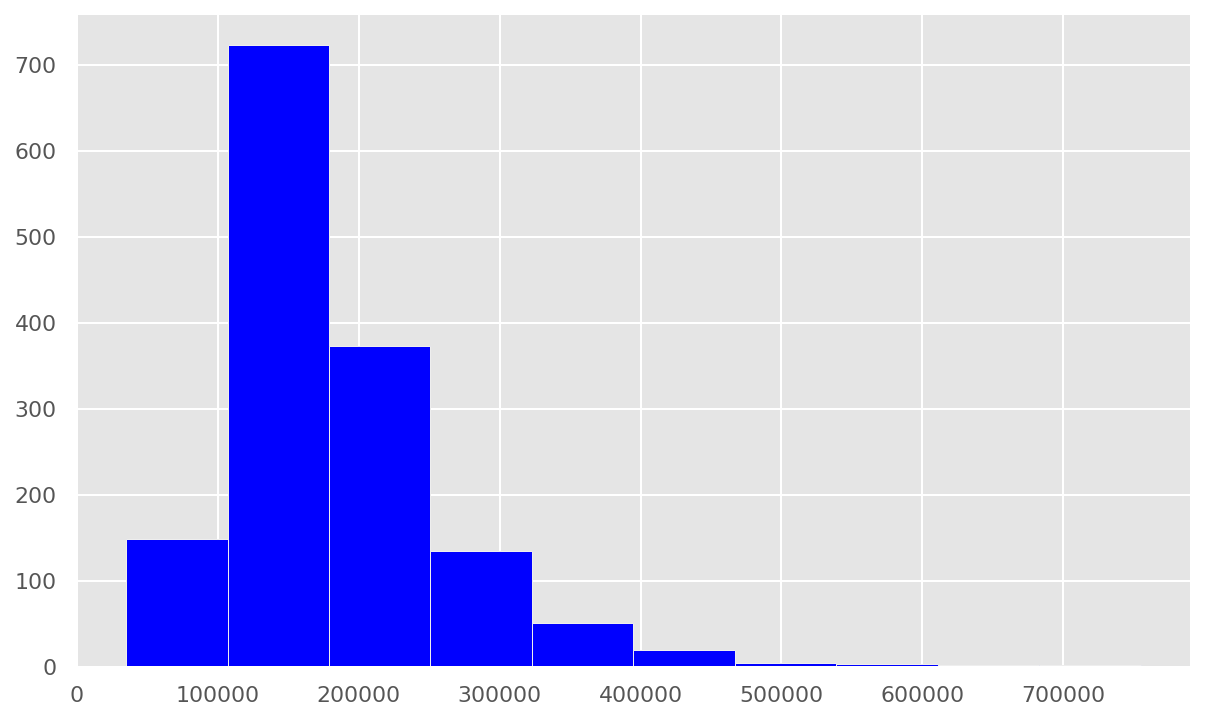

In [7]:
print ("Skew is:", train.SalePrice.skew())
print ("Kurt is:", train.SalePrice.kurt())
plt.hist(train.SalePrice, color='blue')
plt.show()

The skewness and the kurtosis show that the sale prices deviate from the normal distribution and that there is a peak.  
We want a distribution as normal as possible so we will try to fix this.

We use log method from numpy to transform train.SalePrice

Skew is: 0.12133506220520406
Kurt is: 0.8095319958036296


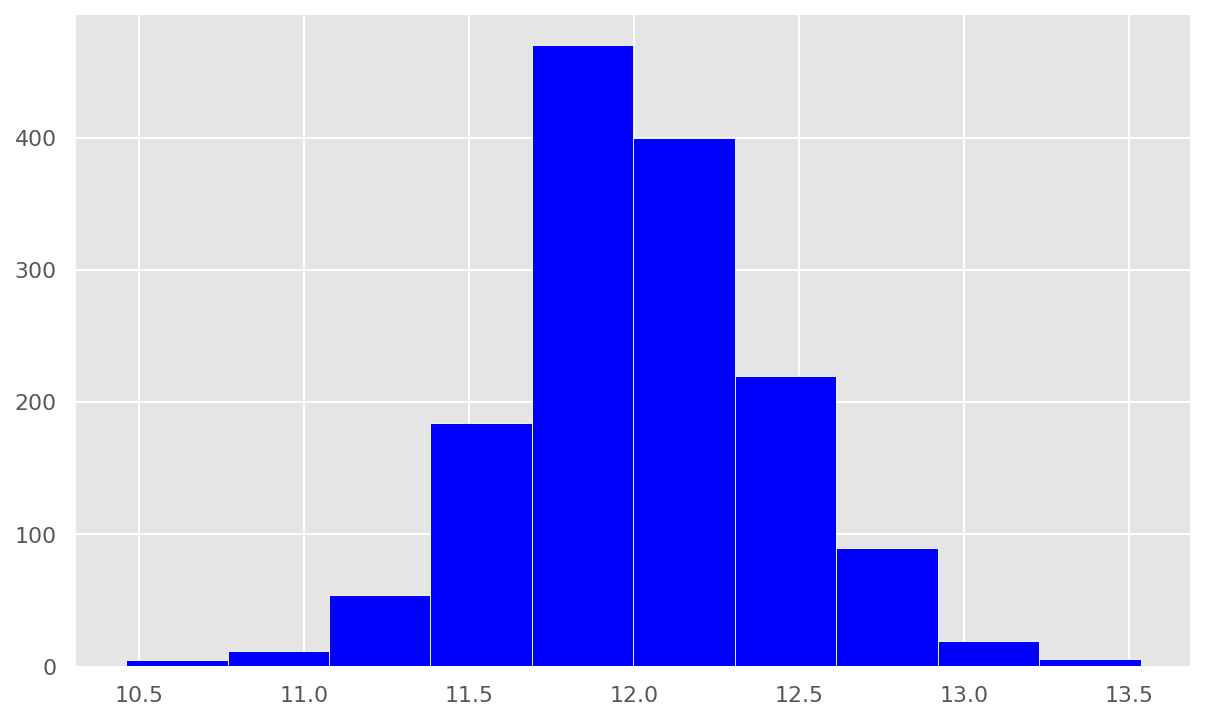

In [8]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
print ("Kurt is:", target.kurt())
plt.hist(target, color='blue')
plt.show()

## Mutivariable analysis - Numericals

In [9]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

### Correlation

In [10]:
corr = numeric_features.corr()

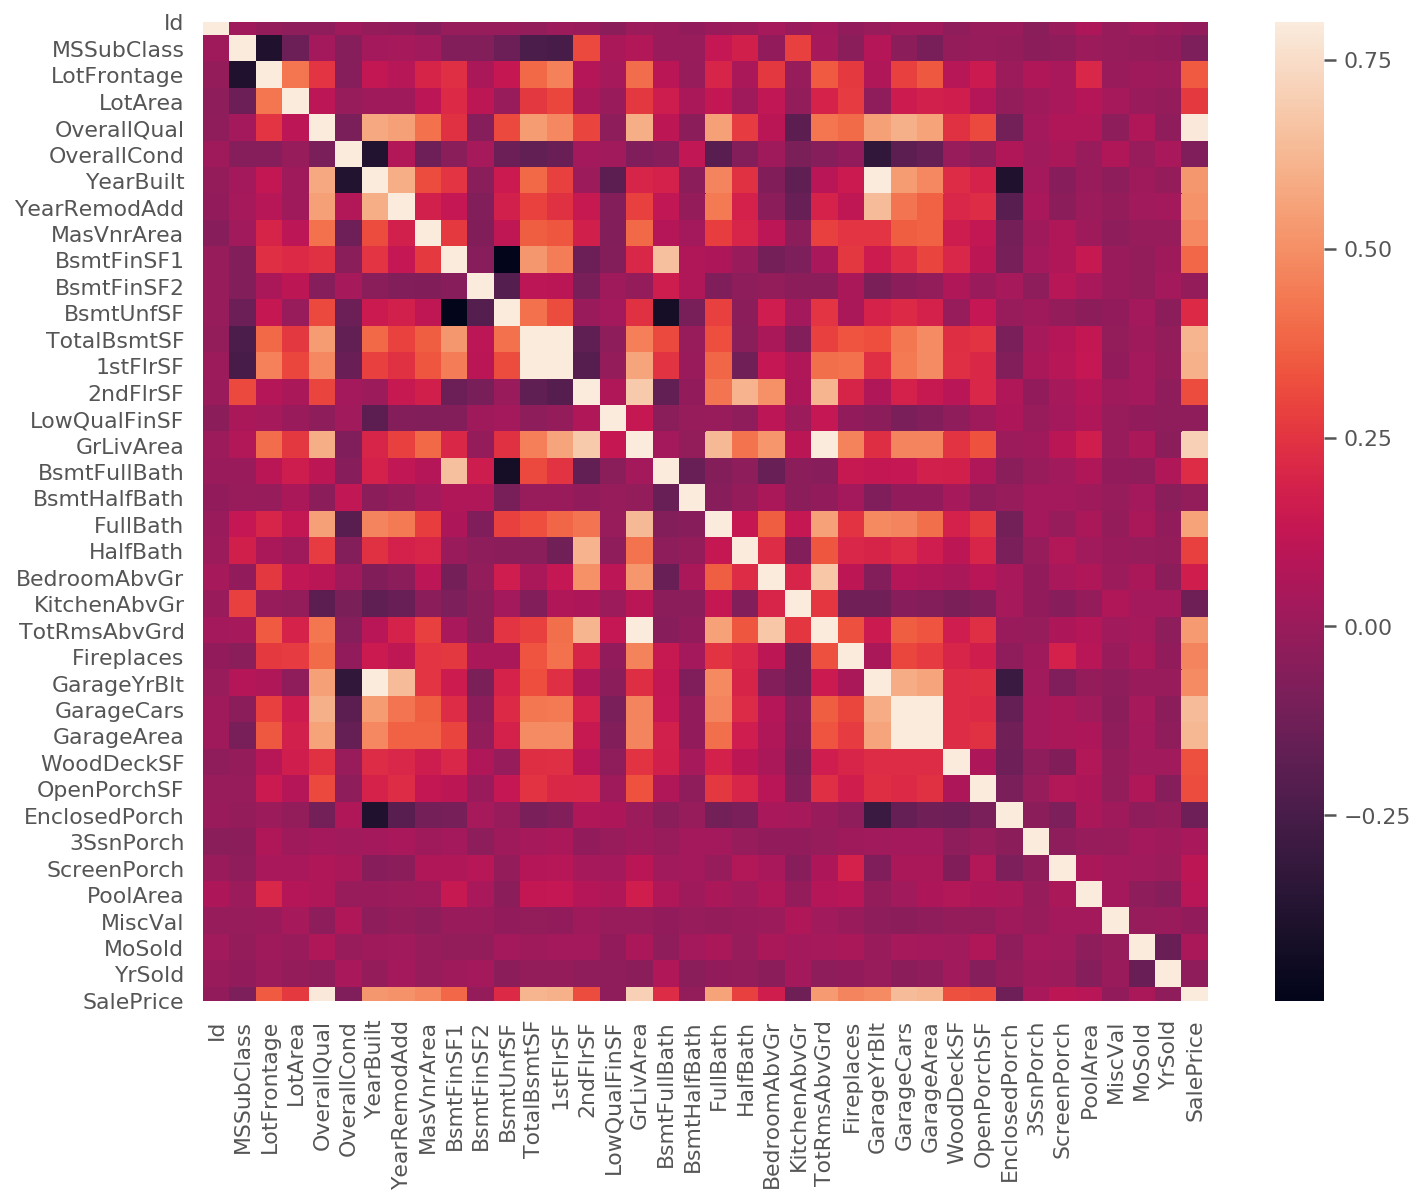

In [11]:
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr, vmax = .8, square = True)

In [12]:
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


The first five features are the most positively correlated with SalePrice, while the next five are the most negatively correlated.

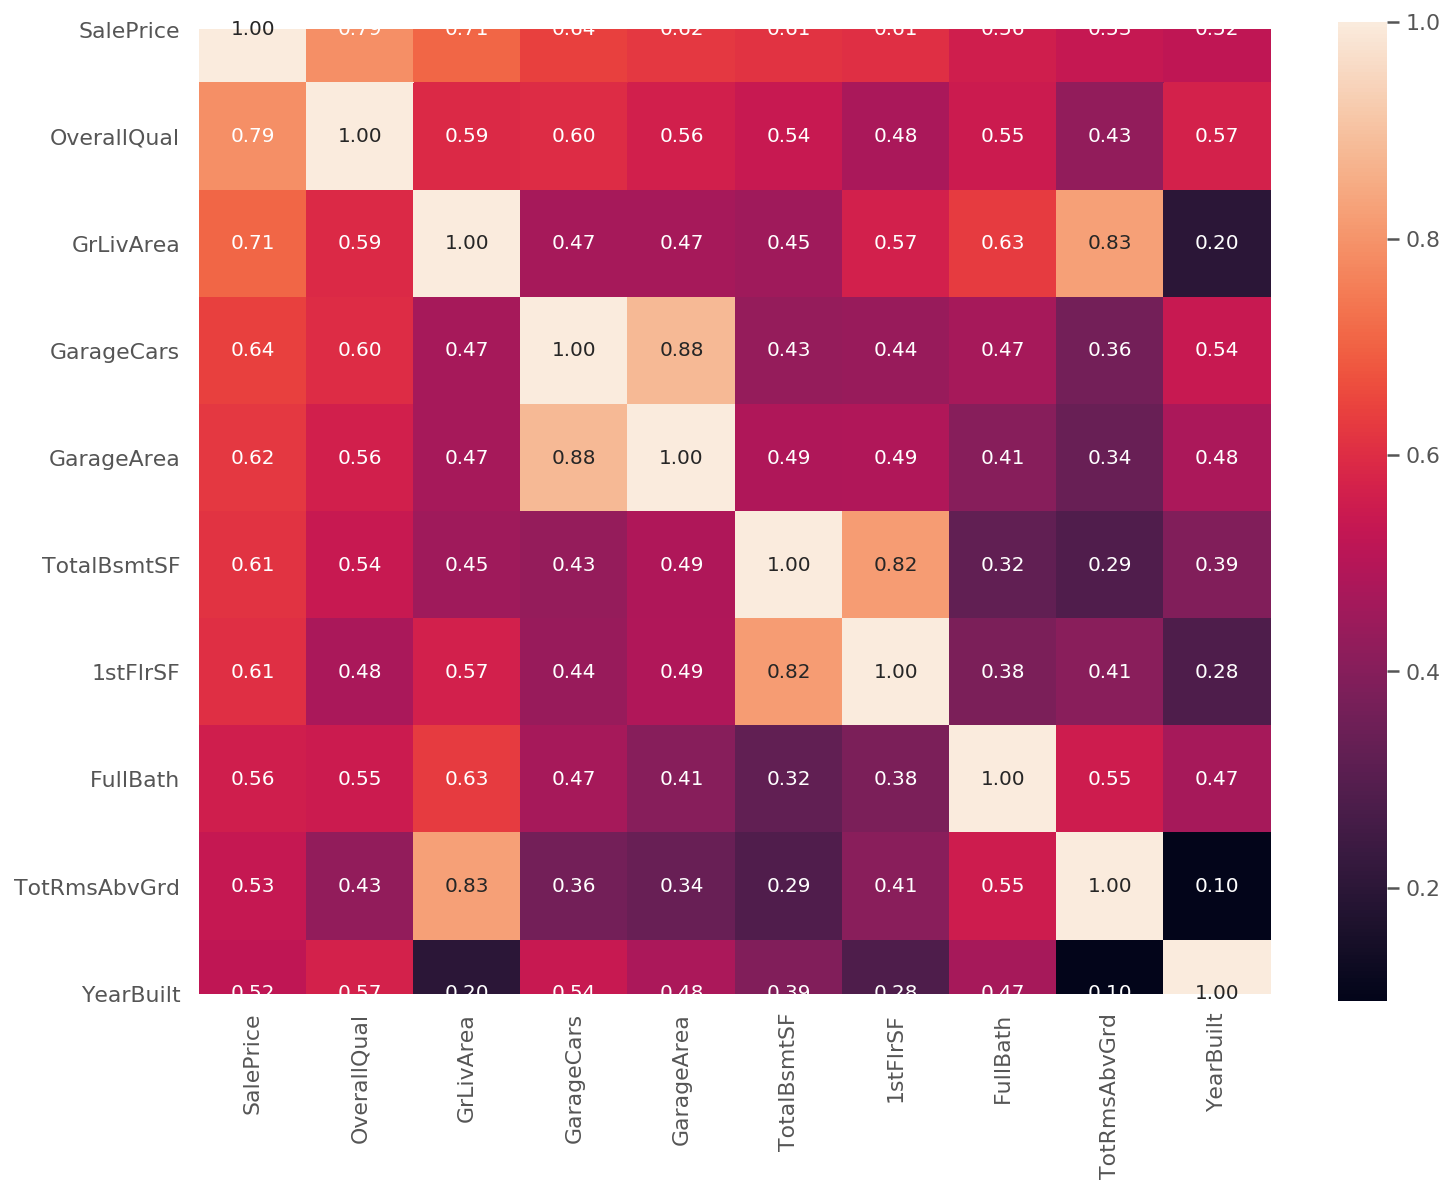

In [13]:
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
most_corr = train[cols].corr()

f, ax = plt.subplots(figsize = (12, 9))
most_corr_heatmap = sns.heatmap(most_corr, 
                             annot = True, 
                             square = True, 
                             fmt = '.2f', 
                             annot_kws = {'size': 10},
                             yticklabels = cols.values,
                             xticklabels = cols.values
                            )

#### OverallQual

In [14]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [15]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)

In [16]:
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


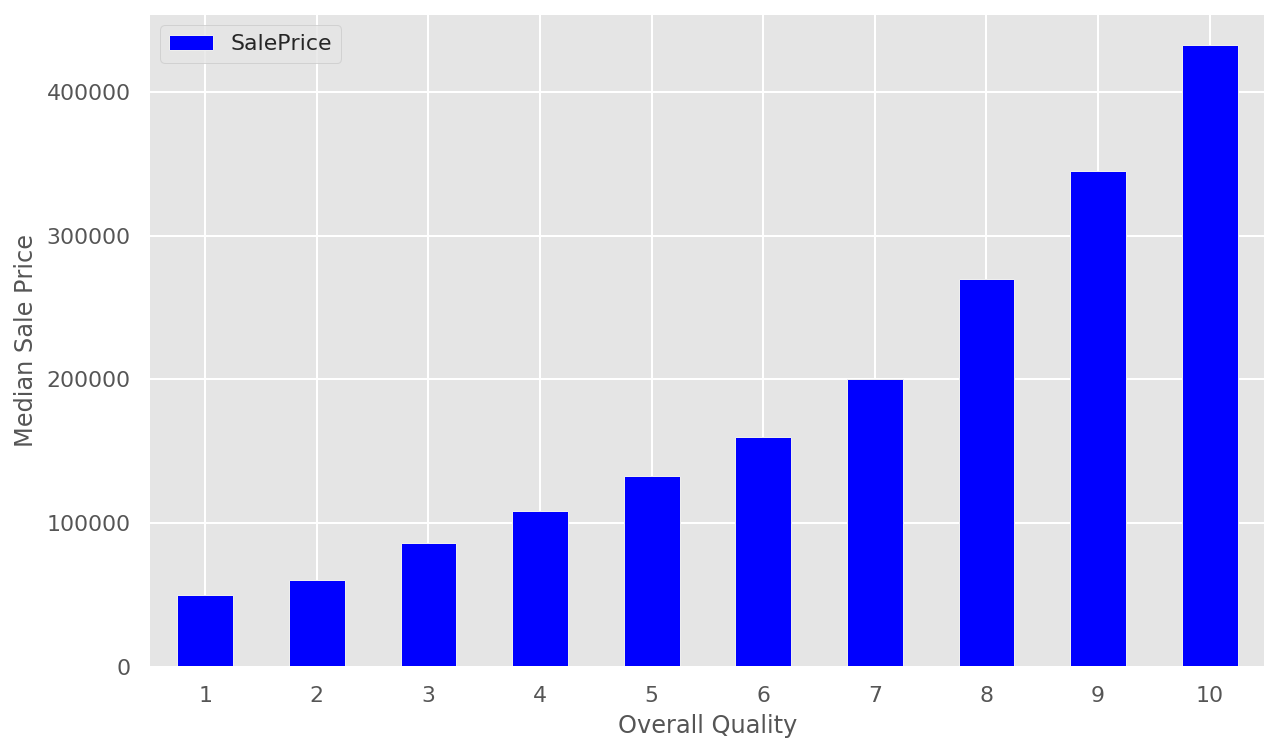

In [17]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

#### GrLivArea

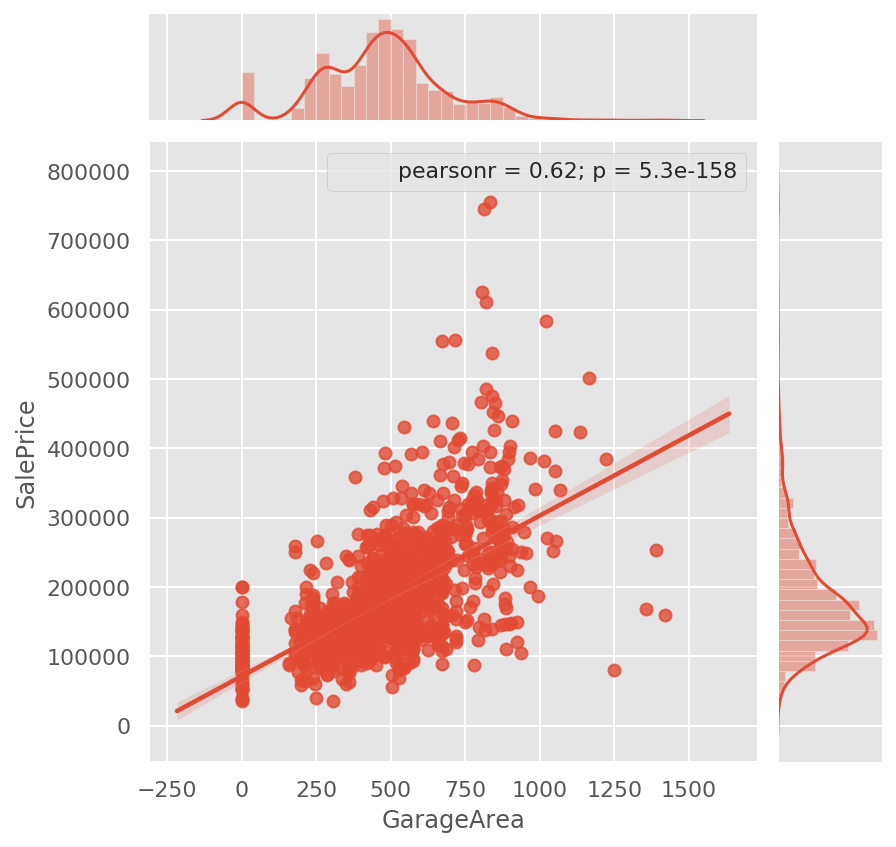

In [18]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

In [19]:
# Remove outliers (two points where GrLivArea > 4000 and SalePrice < 200 000)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index).reset_index(drop=True)

#### GarageCars

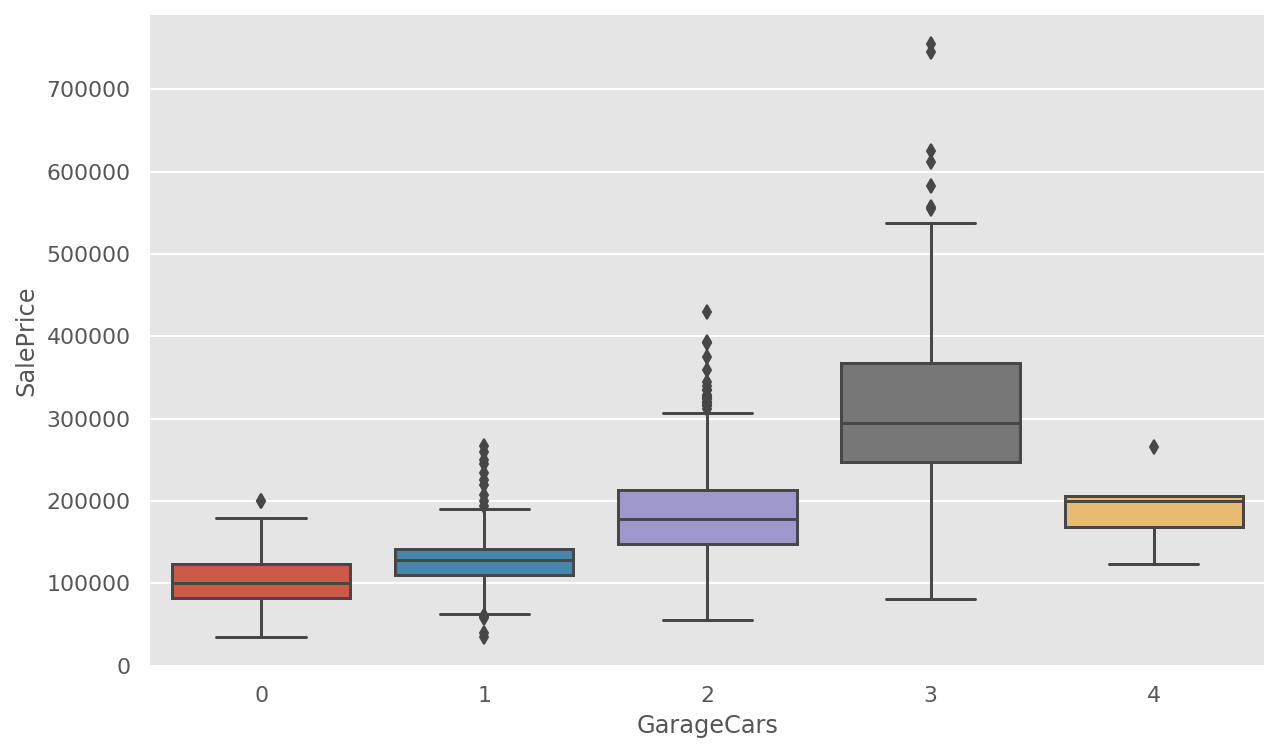

In [20]:
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

In [21]:
# Remove outliers (where GarageCars > 3 and SalePrice < 300 000)
train = train.drop(train[(train['GarageCars'] > 3) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

#### GarageArea

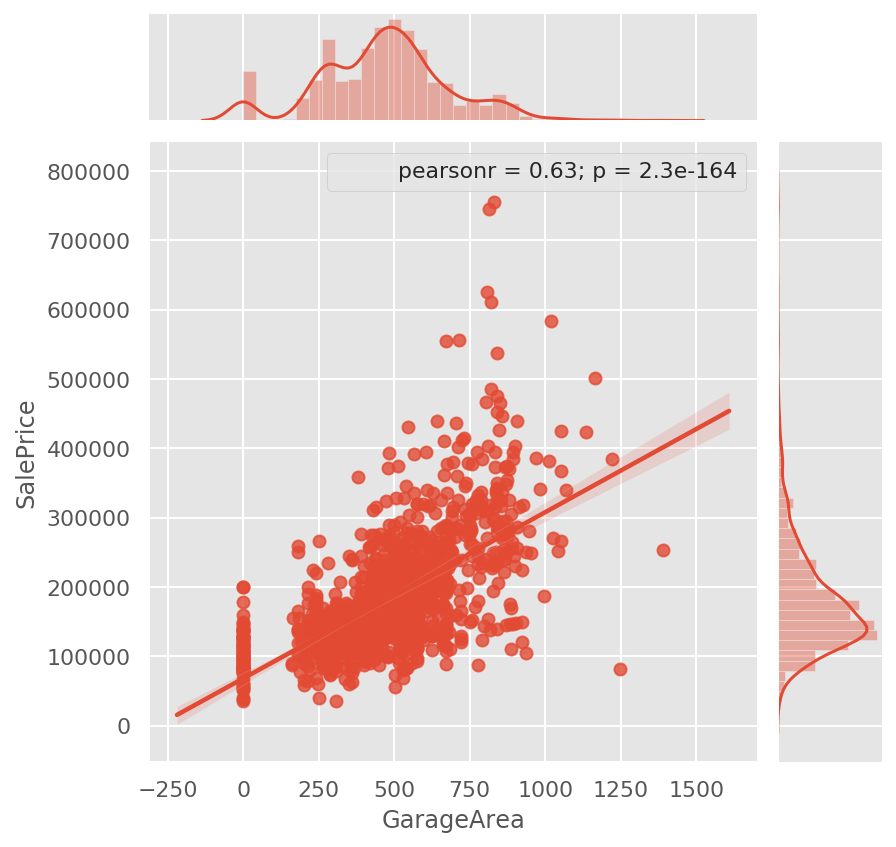

In [22]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

In [23]:
# Remove outliers GarageArea > 1200 and SalePrice < 300000
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

#### TotalBsmtSF

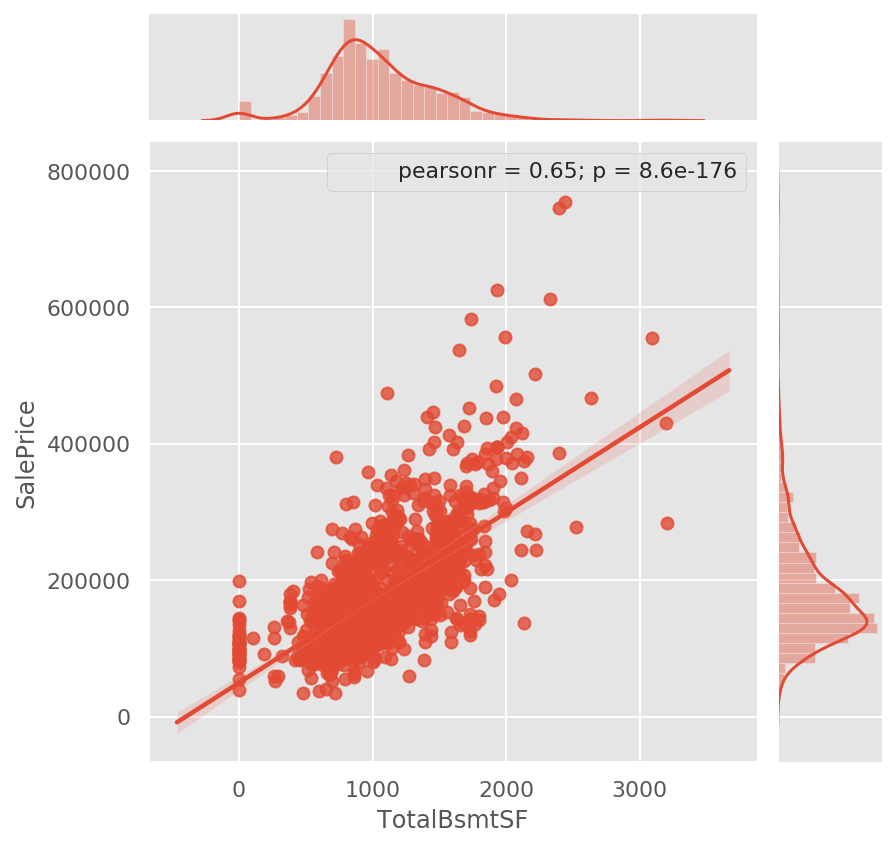

In [24]:
sns.jointplot(x=train['TotalBsmtSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

#### 1stFlrSF

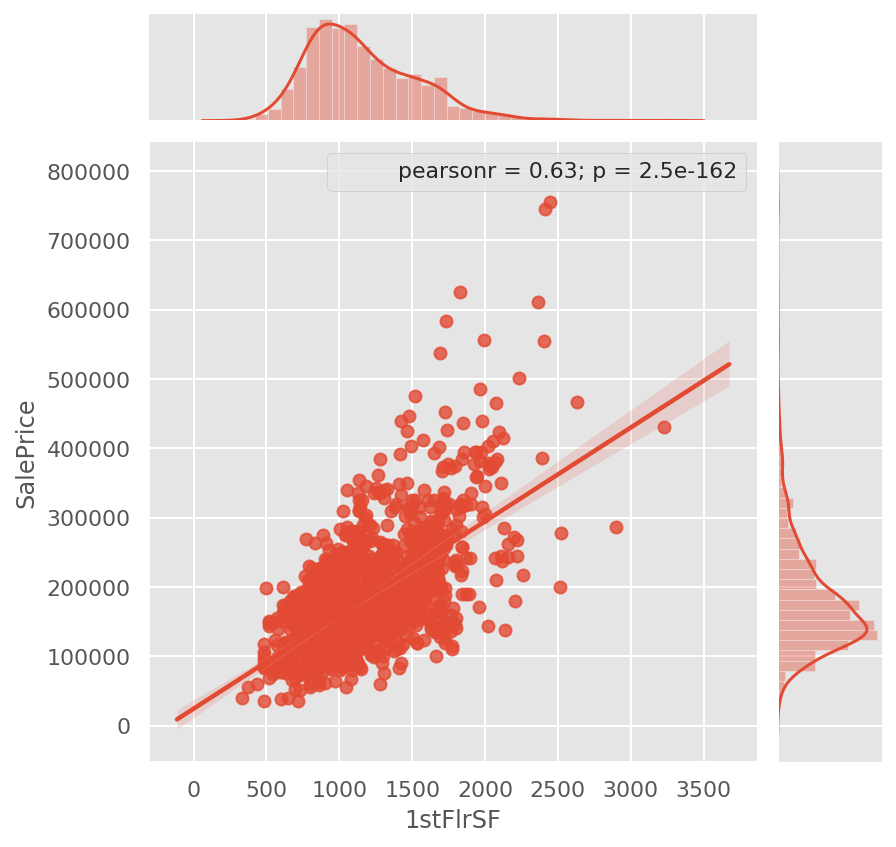

In [25]:
sns.jointplot(x=train['1stFlrSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

#### TotRmsAbvGrd

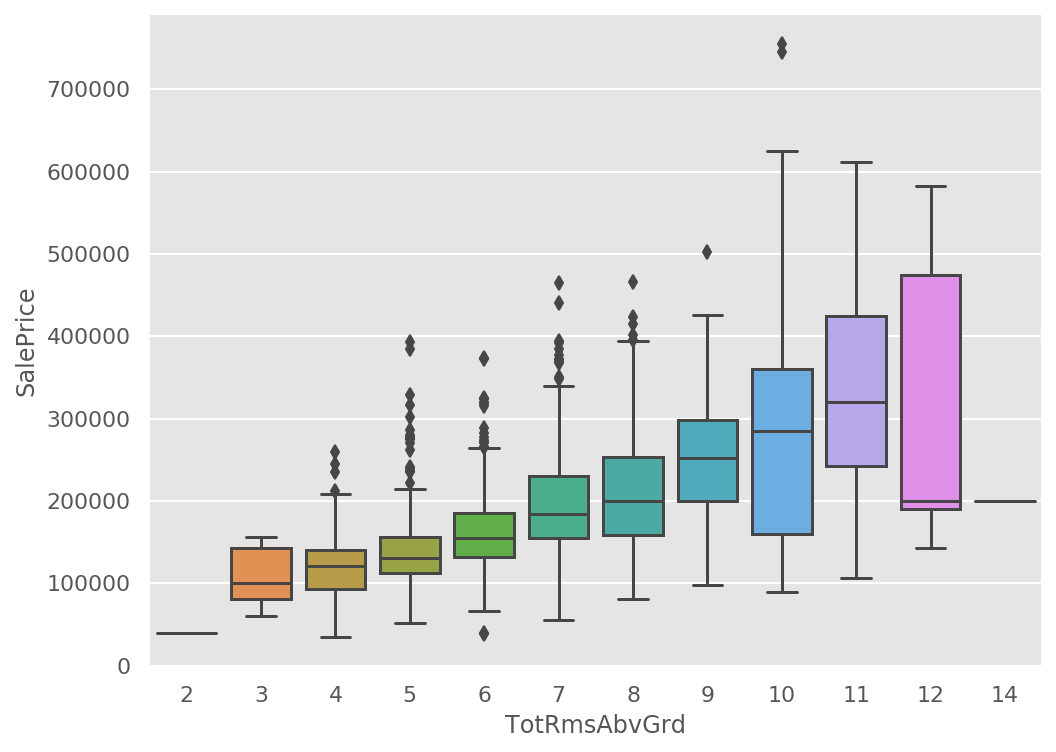

In [26]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

#### YearBuilt

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

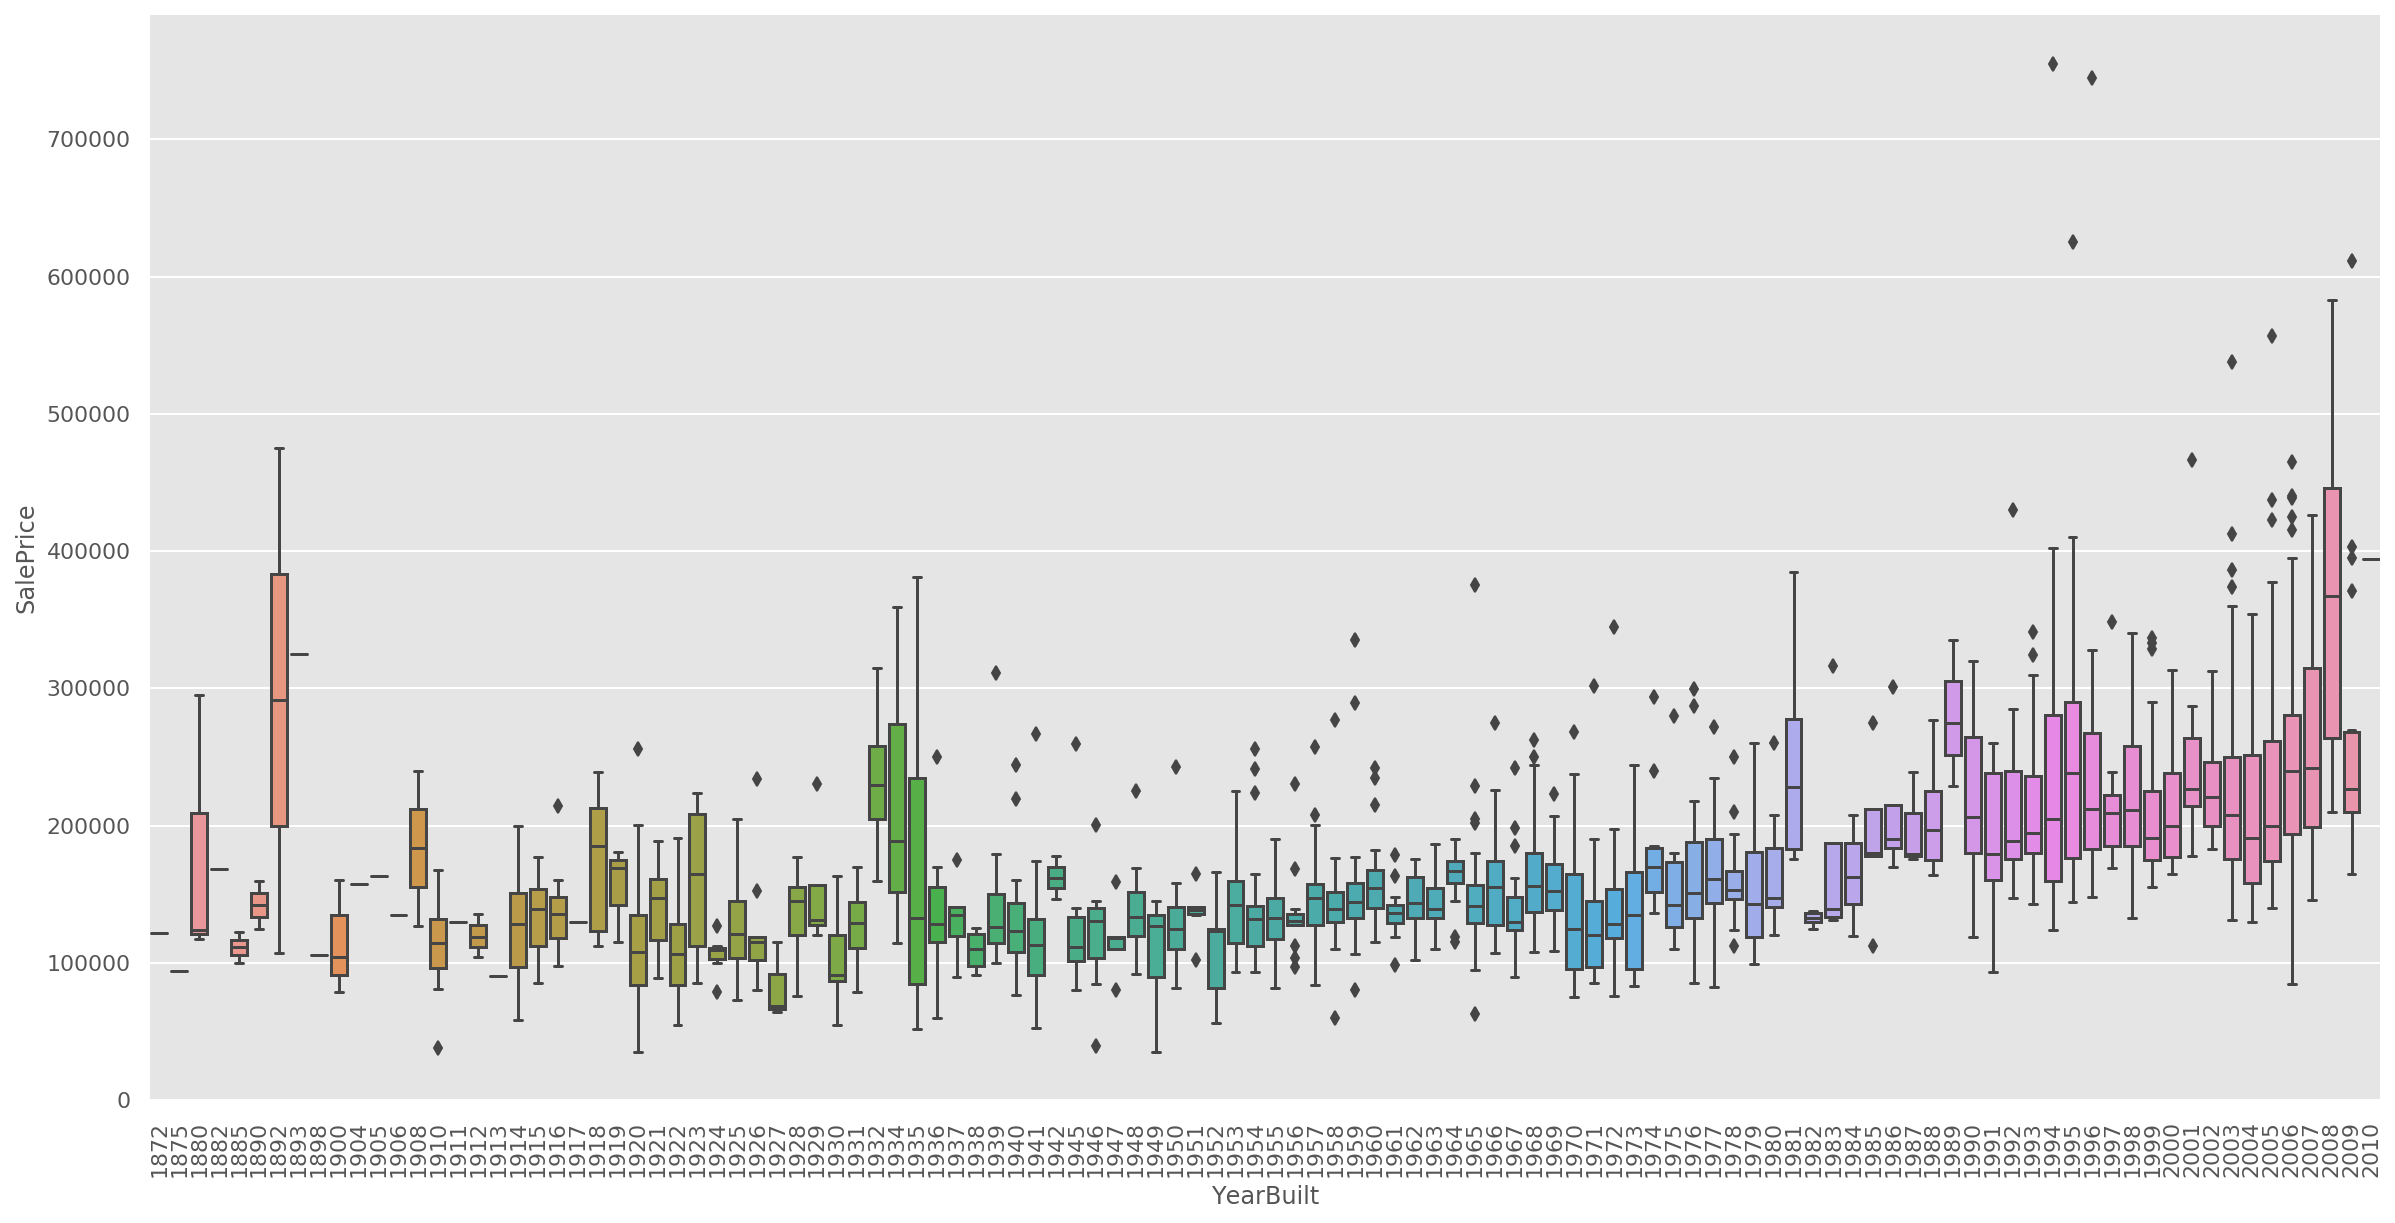

In [27]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = train['YearBuilt'], y = train['SalePrice'])
plt.xticks(rotation = 90)

### Handling Missing Values

In [28]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1445
MiscFeature,1398
Alley,1361
Fence,1171
FireplaceQu,686
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


With the help of the description file, we can say :

* **PoolQC** : data description says NA means "No Pool"
* **MiscFeature** : data description says NA means "no misc feature"
* **Alley** : data description says NA means "no alley access"
* **Fence** : data description says NA means "no fence"
* **FireplaceQu** : data description says NA means "no fireplace"
* **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with "None".
* **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0.
* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: Replacing missing data with 0.
* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there isn't a basement.
* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* **MSZoning** (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
* **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* **Functional** : data description says NA means typical.
* **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* **Exterior1st and Exterior2nd **: Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
* **SaleType** : Fill in again with most frequent which is "WD"
* **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [29]:
datasets = [train, test]

for dataset in datasets:
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                'MasVnrArea'):
        dataset[col] = dataset[col].fillna(0)
        
    dataset.drop(['Utilities'], axis=1, inplace=True)

### Features Engineering and Transformation

In [30]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
test = test.select_dtypes(include=[np.number]).interpolate().dropna()

In [31]:
data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1447,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1448,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1449,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [32]:
sum(data.isnull().sum() != 0)
sum(test.isnull().sum() != 0)

0

## Modeling

In [33]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

### Train-test split

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
                          X, y, random_state=42, test_size=.33)

In [35]:
X_test = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

### Feature Scaling

In [36]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

In [37]:
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train = scaler_y.transform(y_train.values.reshape(-1,1))
y_val = scaler_y.transform(y_val.values.reshape(-1,1))

#### Create model

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

seed = 7
np.random.seed(seed)
input_dim = X_train.shape[1]

# Model
model = Sequential()
model.add(Dense(200, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               7400      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 7,601
Trainable params: 7,601
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=5)

Train on 972 samples, validate on 479 samples
Epoch 1/50
972/972 [==============================] - 1s 695us/step - loss: 4.0637 - val_loss: 50.5199
Epoch 2/50
972/972 [==============================] - 1s 948us/step - loss: 3.4750 - val_loss: 8.4302
Epoch 3/50
972/972 [==============================] - 1s 633us/step - loss: 0.8289 - val_loss: 0.4845
Epoch 4/50
972/972 [==============================] - 0s 512us/step - loss: 1.1612 - val_loss: 0.4070
Epoch 5/50
972/972 [==============================] - 1s 570us/step - loss: 13.5388 - val_loss: 4.8321
Epoch 6/50
972/972 [==============================] - 0s 506us/step - loss: 3.6322 - val_loss: 0.5606
Epoch 7/50
972/972 [==============================] - 1s 660us/step - loss: 1.0802 - val_loss: 4.9246
Epoch 8/50
972/972 [==============================] - 1s 573us/step - loss: 1.4398 - val_loss: 1.8230
Epoch 9/50
972/972 [==============================] - 1s 578us/step - loss: 3.7460 - val_loss: 0.2135
Epoch 10/50
972/972 [=============

#### Visualization

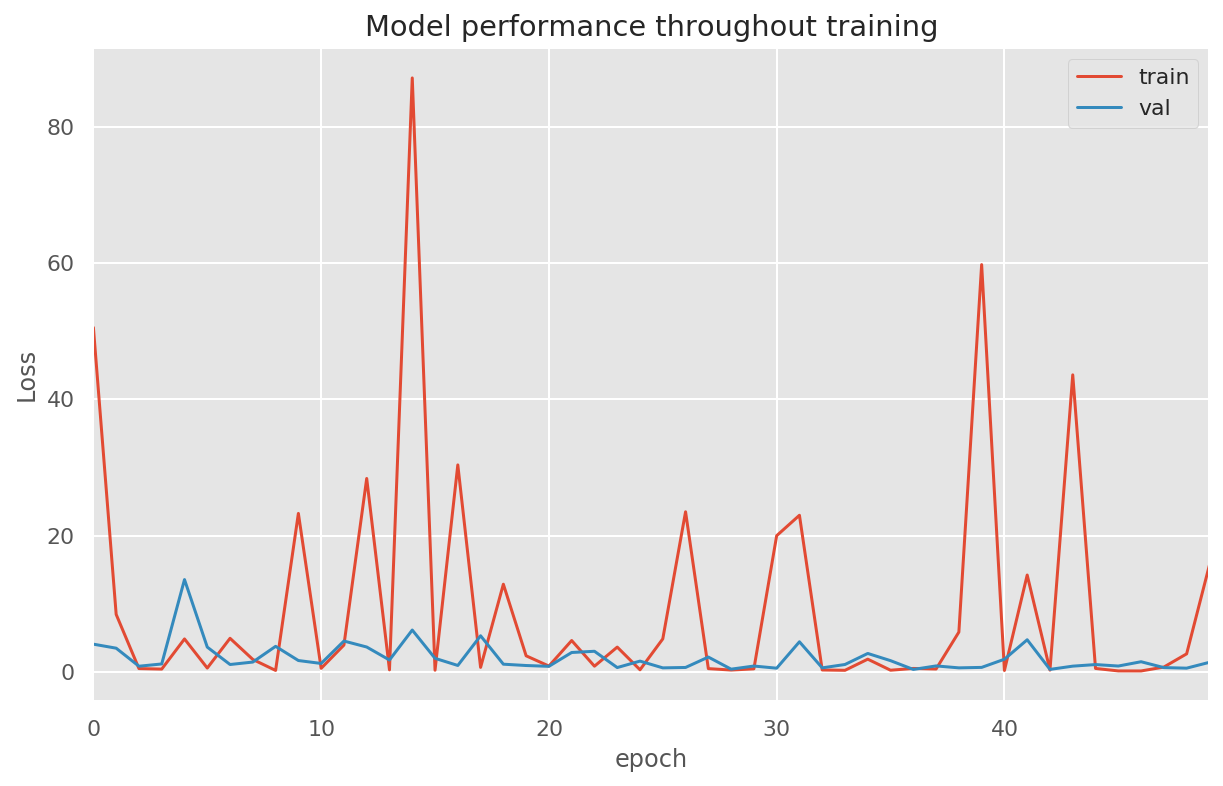

In [40]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Submission

#### Create submission dataFrame

In [41]:
submission = pd.DataFrame()
submission['Id'] = test.Id

#X_test = test.select_dtypes(
        #include=[np.number]).drop(['Id'], axis=1).interpolate()

#### Test model on the test set

In [42]:
predictions = model.predict(X_test)

Transform the predictions to the correct form because we have scaled and log values for SalePrice

In [43]:
inverse_transform_predictions = scaler_y.inverse_transform(predictions)
final_predictions = np.exp(inverse_transform_predictions)

In [44]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [[-7.9482210e-01]
 [-6.8831635e+01]
 [ 2.7222362e-01]
 [ 3.1846035e-01]
 [ 9.8347068e-03]] 

Final predictions are: 
 [[1.0912229e+05]
 [6.8562558e-11]
 [1.8894223e+05]
 [1.9349075e+05]
 [1.6508291e+05]]


In [45]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,1.091223e+05
1,1462,6.856256e-11
2,1463,1.889422e+05
3,1464,1.934908e+05
4,1465,1.650829e+05


In [46]:
submission.to_csv('output/submission_keras_numericals.csv', index=False)